# Enable Agent Tutorial Part 1: PyTorch 딥러닝 모델 학습

## 개요

Spaceship Titanic 데이터셋을 사용하여 승객의 다른 차원 이동(Transported) 여부를 예측하는 PyTorch 딥러닝 분류 모델을 학습한다.

## Spaceship Titanic 데이터셋

2912년, 타이타닉 우주선이 시공간 이상 현상과 충돌하여 일부 승객이 다른 차원으로 이동되었다. 이 데이터셋은 승객 정보를 바탕으로 이동 여부를 예측하는 이진 분류 문제이다.

### 특성 설명

| 특성 | 설명 | 인코딩 |
|------|------|--------|
| HomePlanet | 출발 행성 | 0: Earth, 1: Europa, 2: Mars, 3: Unknown |
| CryoSleep | 냉동 수면 여부 | 0: No, 1: Yes |
| Destination | 목적지 행성 | 0: TRAPPIST-1e, 1: PSO J318.5-22, 2: 55 Cancri e |
| Age | 나이 | 연속형 |
| VIP | VIP 서비스 여부 | 0: No, 1: Yes |
| RoomService | 룸서비스 지출 | 연속형 |
| FoodCourt | 푸드코트 지출 | 연속형 |
| ShoppingMall | 쇼핑몰 지출 | 연속형 |
| Spa | 스파 지출 | 연속형 |
| VRDeck | VR 데크 지출 | 연속형 |
| **Transported** | **다른 차원 이동 여부 (Target)** | 0: No, 1: Yes |

## 학습 내용

- 데이터 전처리 및 표준화
- PyTorch Dataset 및 DataLoader 구성
- 신경망 모델 설계 및 학습
- 모델 평가 및 저장

---
## 1. 라이브러리 임포트

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 디바이스: {device}")

PyTorch 버전: 2.8.0
CUDA 사용 가능: False
사용 디바이스: cpu


---
## 2. 데이터 로드 및 탐색

In [2]:
df = pd.read_csv('dataset/spaceship-preprocessing.csv')

print(f"데이터셋 크기: {df.shape[0]}개 샘플, {df.shape[1]}개 특성")
print()
df.head(10)

데이터셋 크기: 8693개 샘플, 11개 특성



,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,0
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,1
2,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0
3,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,1
5,0,0,1,44.0,0,0.0,483.0,0.0,291.0,0.0,1
6,0,0,2,26.0,0,42.0,1539.0,3.0,0.0,0.0,1
7,0,1,2,28.0,0,0.0,0.0,0.0,0.0,0.0,1
8,0,0,2,35.0,0,0.0,785.0,17.0,216.0,0.0,1
9,1,1,0,14.0,0,0.0,0.0,0.0,0.0,0.0,1


In [3]:
print("=== 데이터 타입 ===")
print(df.dtypes)
print()
print("=== 결측치 현황 ===")
print(df.isnull().sum())

=== 데이터 타입 ===
HomePlanet        int64
CryoSleep         int64
Destination       int64
Age             float64
VIP               int64
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Transported       int64
dtype: object

=== 결측치 현황 ===
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64


In [4]:
print("=== 기초 통계량 ===")
df.describe()

=== 기초 통계량 ===


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,0.719199,0.399287,1.515242,28.790291,0.069596,220.009318,448.434027,169.572300,304.588865,298.261820,0.503624
std,0.863402,0.538345,0.840148,14.341404,0.333871,660.519050,1595.790627,598.007164,1125.562559,1134.126417,0.500016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,2.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,2.000000,37.000000,0.000000,41.000000,61.000000,22.000000,53.000000,40.000000,1.000000
max,3.000000,2.000000,3.000000,79.000000,2.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000


In [8]:
print("=== 타겟 변수 분포 ===")
target_counts = df['Transported'].value_counts()
print(f"이동됨 (1): {target_counts[1]}명 ({target_counts[1]/len(df)*100:.1f}%)")
print(f"이동 안됨 (0): {target_counts[0]}명 ({target_counts[0]/len(df)*100:.1f}%)")

=== 타겟 변수 분포 ===
이동됨 (1): 4378명 (50.4%)
이동 안됨 (0): 4315명 (49.6%)


---
## 3. 데이터 시각화

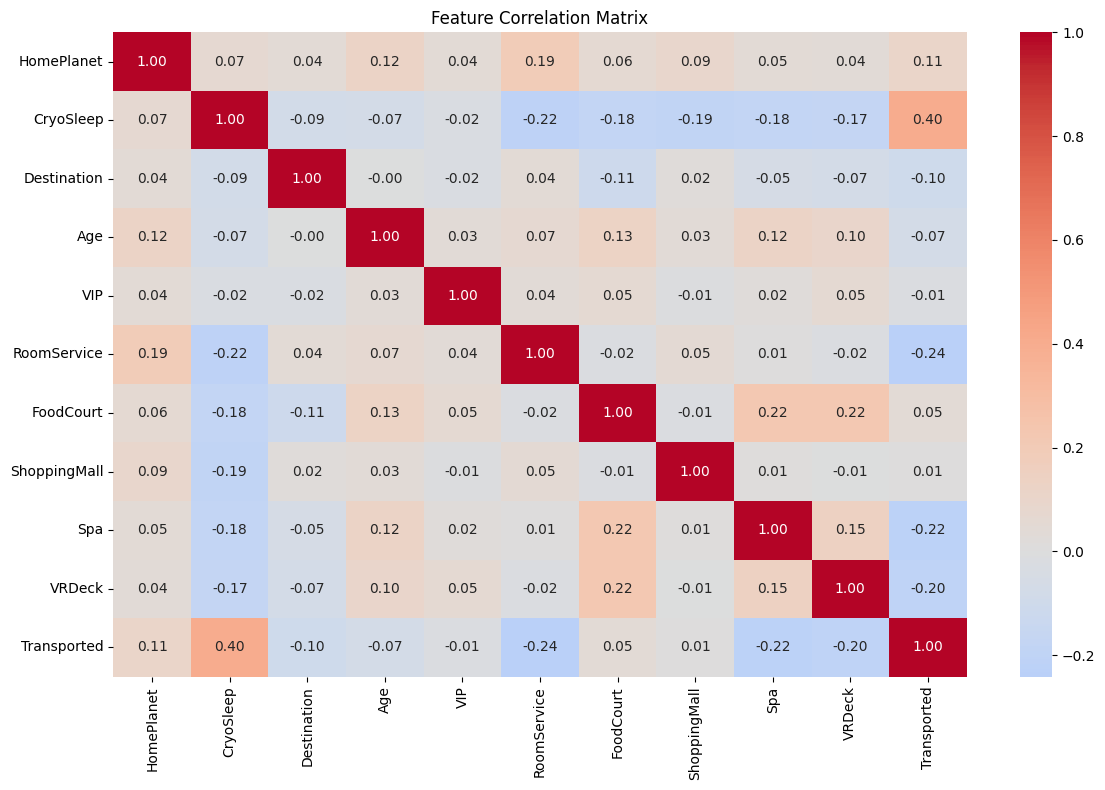

In [8]:
plt.figure(figsize=(12, 8))
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

---
## 4. 데이터 전처리

### 전처리 과정

1. 특성과 타겟 분리
2. 학습/검증/테스트 셋 분할 (60:20:20)
3. StandardScaler로 정규화 (학습 데이터 기준)

In [9]:
feature_names = ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 
                 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
target_name = 'Transported'

X = df[feature_names].values
y = df[target_name].values

print(f"특성 shape: {X.shape}")
print(f"타겟 shape: {y.shape}")

특성 shape: (8693, 10)
타겟 shape: (8693,)


In [10]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"학습 셋: {X_train.shape[0]}개 ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"검증 셋: {X_val.shape[0]}개 ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"테스트 셋: {X_test.shape[0]}개 ({X_test.shape[0]/len(X)*100:.1f}%)")

학습 셋: 5215개 (60.0%)
검증 셋: 1739개 (20.0%)
테스트 셋: 1739개 (20.0%)


In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("정규화 완료")
print(f"학습 데이터 평균: {X_train_scaled.mean(axis=0).round(4)}")
print(f"학습 데이터 표준편차: {X_train_scaled.std(axis=0).round(4)}")

정규화 완료
학습 데이터 평균: [ 0. -0.  0. -0. -0. -0. -0.  0.  0.  0.]
학습 데이터 표준편차: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


---
## 5. PyTorch 텐서 및 DataLoader 생성

In [12]:
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test)

print(f"텐서 생성 완료")
print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")

텐서 생성 완료
X_train_tensor shape: torch.Size([5215, 10])
y_train_tensor shape: torch.Size([5215])


In [13]:
batch_size = 64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoader 생성 완료")
print(f"학습 배치 수: {len(train_loader)}")
print(f"검증 배치 수: {len(val_loader)}")
print(f"테스트 배치 수: {len(test_loader)}")

DataLoader 생성 완료
학습 배치 수: 82
검증 배치 수: 28
테스트 배치 수: 28


---
## 6. 신경망 모델 정의

### 모델 아키텍처

```
Input (10) -> Linear(64) -> ReLU -> Dropout(0.3)
          -> Linear(32) -> ReLU -> Dropout(0.3)
          -> Linear(16) -> ReLU
          -> Linear(1) -> Sigmoid -> Output
```

In [14]:
class SpaceshipClassifier(nn.Module):
    """Spaceship Titanic 이진 분류 신경망"""
    
    def __init__(self, input_dim=10, hidden_dims=[64, 32, 16], dropout_rate=0.3):
        super(SpaceshipClassifier, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for i, hidden_dim in enumerate(hidden_dims):
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            if i < len(hidden_dims) - 1:
                layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x).squeeze()

model = SpaceshipClassifier(input_dim=10).to(device)
print(model)

SpaceshipClassifier(
  (network): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


In [15]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"전체 파라미터 수: {total_params:,}")
print(f"학습 가능 파라미터 수: {trainable_params:,}")

전체 파라미터 수: 3,329
학습 가능 파라미터 수: 3,329


---
## 7. 모델 학습

In [17]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print("손실 함수: Binary Cross Entropy Loss")
print("옵티마이저: Adam (lr=0.001)")
print("스케줄러: ReduceLROnPlateau")

손실 함수: Binary Cross Entropy Loss
옵티마이저: Adam (lr=0.001)
스케줄러: ReduceLROnPlateau


In [18]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item()
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy, all_preds, all_labels, all_probs

In [19]:
num_epochs = 100
early_stop_patience = 15
best_val_loss = float('inf')
patience_counter = 0

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("=== 모델 학습 시작 ===")
print(f"에포크: {num_epochs}, Early Stopping: {early_stop_patience}")
print()

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion, device)
    
    scheduler.step(val_loss)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1:3d}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    if patience_counter >= early_stop_patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

model.load_state_dict(best_model_state)
print("\n최적 모델 로드 완료")

=== 모델 학습 시작 ===
에포크: 100, Early Stopping: 15

Epoch [ 10/100] Train Loss: 0.4501, Train Acc: 0.7900 | Val Loss: 0.4549, Val Acc: 0.7752
Epoch [ 20/100] Train Loss: 0.4340, Train Acc: 0.7992 | Val Loss: 0.4463, Val Acc: 0.7803
Epoch [ 30/100] Train Loss: 0.4249, Train Acc: 0.8061 | Val Loss: 0.4452, Val Acc: 0.7780
Epoch [ 40/100] Train Loss: 0.4239, Train Acc: 0.8000 | Val Loss: 0.4398, Val Acc: 0.7763
Epoch [ 50/100] Train Loss: 0.4204, Train Acc: 0.8035 | Val Loss: 0.4385, Val Acc: 0.7763
Epoch [ 60/100] Train Loss: 0.4165, Train Acc: 0.8061 | Val Loss: 0.4370, Val Acc: 0.7792
Epoch [ 70/100] Train Loss: 0.4145, Train Acc: 0.8061 | Val Loss: 0.4356, Val Acc: 0.7752
Epoch [ 80/100] Train Loss: 0.4153, Train Acc: 0.8063 | Val Loss: 0.4356, Val Acc: 0.7769
Epoch [ 90/100] Train Loss: 0.4105, Train Acc: 0.8079 | Val Loss: 0.4352, Val Acc: 0.7798
Epoch [100/100] Train Loss: 0.4103, Train Acc: 0.8082 | Val Loss: 0.4353, Val Acc: 0.7769

최적 모델 로드 완료


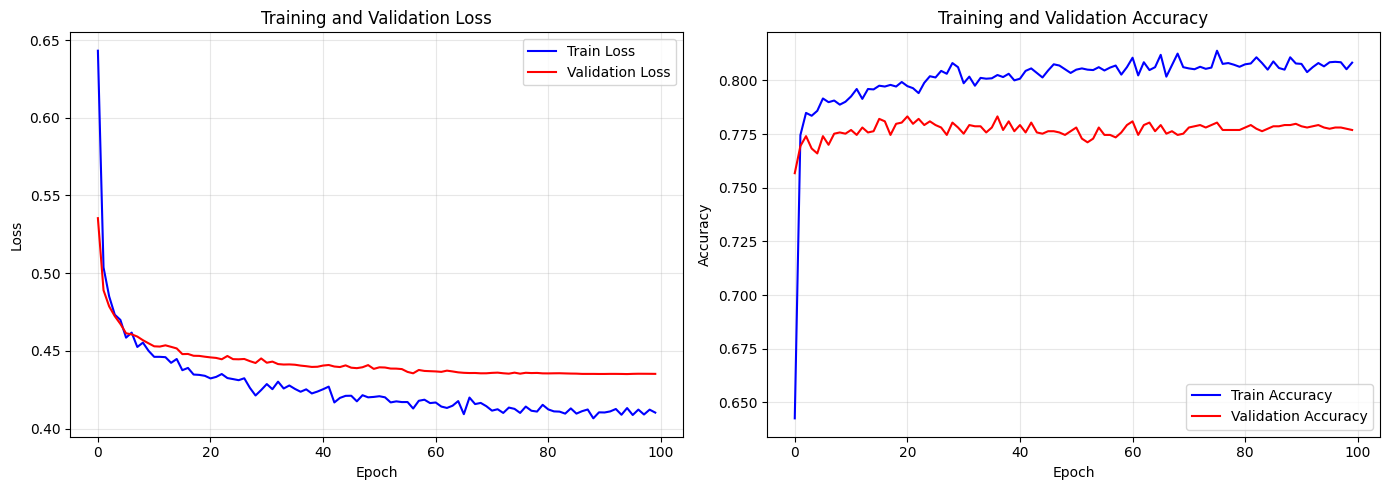

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax = axes[0]
ax.plot(history['train_loss'], label='Train Loss', color='blue')
ax.plot(history['val_loss'], label='Validation Loss', color='red')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Accuracy
ax = axes[1]
ax.plot(history['train_acc'], label='Train Accuracy', color='blue')
ax.plot(history['val_acc'], label='Validation Accuracy', color='red')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 8. 테스트 셋 평가

In [21]:
test_loss, test_acc, test_preds, test_labels, test_probs = evaluate(model, test_loader, criterion, device)

print("=== 테스트 셋 평가 결과 ===")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC-ROC: {roc_auc_score(test_labels, test_probs):.4f}")

=== 테스트 셋 평가 결과 ===
Test Loss: 0.4326
Test Accuracy: 0.7947
Test AUC-ROC: 0.8772


In [22]:
print("=== Classification Report ===")
print(classification_report(test_labels, test_preds, target_names=['Not Transported', 'Transported']))

=== Classification Report ===
                 precision    recall  f1-score   support

Not Transported       0.82      0.75      0.78       863
    Transported       0.77      0.84      0.81       876

       accuracy                           0.79      1739
      macro avg       0.80      0.79      0.79      1739
   weighted avg       0.80      0.79      0.79      1739



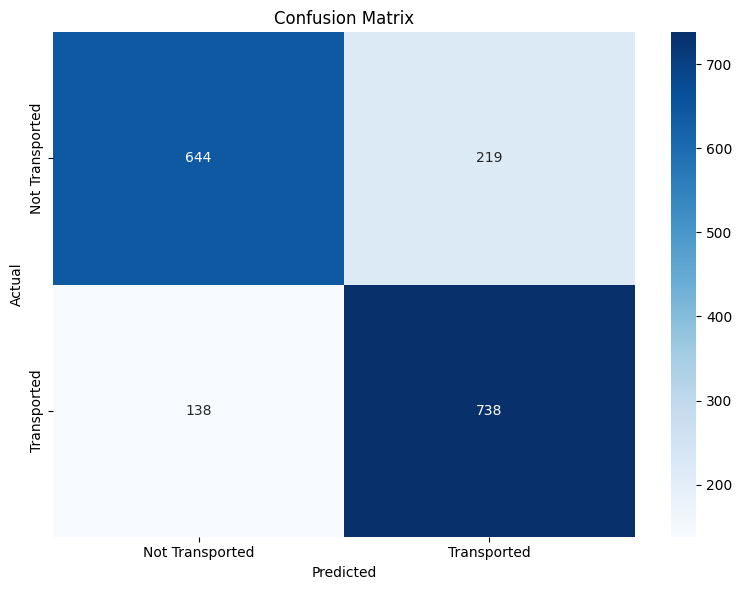

In [23]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Transported', 'Transported'],
            yticklabels=['Not Transported', 'Transported'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

---
## 9. 모델 및 메타데이터 저장

In [24]:
Path('models').mkdir(exist_ok=True)

model_save_path = 'models/spaceship_classifier.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'input_dim': 10,
    'hidden_dims': [64, 32, 16],
    'dropout_rate': 0.3
}, model_save_path)

print(f"모델 저장 완료: {model_save_path}")

모델 저장 완료: models/spaceship_classifier.pth


In [25]:
import joblib

scaler_path = 'models/spaceship_scaler.pkl'
joblib.dump(scaler, scaler_path)

print(f"스케일러 저장 완료: {scaler_path}")

스케일러 저장 완료: models/spaceship_scaler.pkl


In [26]:
metadata = {
    'model_type': 'PyTorch Neural Network',
    'architecture': 'SpaceshipClassifier',
    'input_dim': 10,
    'hidden_dims': [64, 32, 16],
    'dropout_rate': 0.3,
    'feature_names': feature_names,
    'target_name': target_name,
    'target_classes': ['Not Transported', 'Transported'],
    'test_accuracy': float(test_acc),
    'test_auc_roc': float(roc_auc_score(test_labels, test_probs)),
    'training_samples': int(X_train.shape[0]),
    'validation_samples': int(X_val.shape[0]),
    'test_samples': int(X_test.shape[0]),
    'scaler_mean': scaler.mean_.tolist(),
    'scaler_scale': scaler.scale_.tolist(),
    'trained_at': datetime.now().isoformat(),
    'pytorch_version': torch.__version__
}

metadata_path = 'models/spaceship_classifier_metadata.json'
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"메타데이터 저장 완료: {metadata_path}")
print()
print(json.dumps(metadata, indent=2, ensure_ascii=False))

메타데이터 저장 완료: models/spaceship_classifier_metadata.json

{
  "model_type": "PyTorch Neural Network",
  "architecture": "SpaceshipClassifier",
  "input_dim": 10,
  "hidden_dims": [
    64,
    32,
    16
  ],
  "dropout_rate": 0.3,
  "feature_names": [
    "HomePlanet",
    "CryoSleep",
    "Destination",
    "Age",
    "VIP",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck"
  ],
  "target_name": "Transported",
  "target_classes": [
    "Not Transported",
    "Transported"
  ],
  "test_accuracy": 0.7947096032202415,
  "test_auc_roc": 0.8772295327439059,
  "training_samples": 5215,
  "validation_samples": 1739,
  "test_samples": 1739,
  "scaler_mean": [
    0.7250239693192714,
    0.40575263662511984,
    1.5041227229146692,
    28.714860977948227,
    0.06845637583892618,
    232.10987535953979,
    440.1823585810163,
    163.34745925215725,
    319.05465004793865,
    285.0329817833174
  ],
  "scaler_scale": [
    0.8682847366465234,
    0.5404851023906941

---
## 10. 저장된 모델 로드 테스트

In [27]:
checkpoint = torch.load(model_save_path, map_location=device, weights_only=True)

loaded_model = SpaceshipClassifier(
    input_dim=checkpoint['input_dim'],
    hidden_dims=checkpoint['hidden_dims'],
    dropout_rate=checkpoint['dropout_rate']
).to(device)

loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.eval()

print("저장된 모델 로드 완료")

저장된 모델 로드 완료


In [28]:
test_sample = {
    'HomePlanet': 0,      # Earth
    'CryoSleep': 1,       # Yes
    'Destination': 2,     # 55 Cancri e
    'Age': 28.0,
    'VIP': 0,             # No
    'RoomService': 0.0,
    'FoodCourt': 0.0,
    'ShoppingMall': 0.0,
    'Spa': 0.0,
    'VRDeck': 0.0
}

input_array = np.array([[test_sample[f] for f in feature_names]])
input_scaled = scaler.transform(input_array)
input_tensor = torch.FloatTensor(input_scaled).to(device)

with torch.no_grad():
    prob = loaded_model(input_tensor).item()
    prediction = 1 if prob > 0.5 else 0

print("=== 예측 테스트 ===")
print(f"입력: {test_sample}")
print(f"예측 확률: {prob:.4f}")
print(f"예측 결과: {'Transported' if prediction == 1 else 'Not Transported'}")

=== 예측 테스트 ===
입력: {'HomePlanet': 0, 'CryoSleep': 1, 'Destination': 2, 'Age': 28.0, 'VIP': 0, 'RoomService': 0.0, 'FoodCourt': 0.0, 'ShoppingMall': 0.0, 'Spa': 0.0, 'VRDeck': 0.0}
예측 확률: 0.6650
예측 결과: Transported
